In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Double spending time distribution with random walk

The difference between the number of blocks of the public blockchain and the private one is given by 
$$
X_0 = x,\text{ }X_n = X_{n-1}+\xi_n,\text{ for }n\geq1,
$$
where the $\xi_i$'s are iid with probability mass fuunction 

$$
\mathbb{P}(Y = 1)=p\text{ and }\mathbb{P}(Y = -1)=1-p = q.
$$

Define the double spending time as $\tau_0 = \inf\{n\geq0\text{ ; }X_n = 0\}$

We wish to verify the following formula

$$
\mathbb{P}(\tau_0 = n|X_0 = x) = 
\begin{cases}
\frac{x}{n}\binom{n}{(n-x)/2}p^{(n-x)/2}q^{(n+x)/2},& \text{ if }x\text{ is even and }n\geq x, \\
0,&\text{otherwise}.
\end{cases}
$$

via simulations.

1) Write a function **pmf_ds** that compute the probability mass function of the double spending time. the **pmf_ds** takes as argument 

- p the hashpower of the honest miners
- x the number of blocks that the honest chain is ahead of the dishonest one
- n the time horizon

and returns the $\mathbb{P}(\tau_0 = n|X_0 = x)$. Evaluate it with $p= 2/3, x = 2,$ and $n = 6$. 

In [2]:
def pmf_ds(p, x, n):
    q = 1-p
    if x > n or (n - x) % 2 == 1:
        res = 0
    else:
        a = int((n - x) / 2)
        res = x / n * sp.binom(n, a) * p**(a) * q**(a + x)
    return(res)
p, x, n = 2/3, 2, 6
pmf_ds(p, x, n)

0.02743484224965708

2) Verify that it checks out with the probability of double spending

In [3]:
sum([pmf_ds(p, x, k) for k in range(1000)]), ((1-p)/p)**x

(0.2499999999999997, 0.2500000000000001)

3) Write a function **sample_ds_time** that sample value of $\tau_0$ up to given time horizon $n$. **pmf_ds_MC** takes as argument

- K the number of MC runs
- n the time horizon (beyond which we state that $\tau_0 = \infty$)
- p the hashpower of the honest miners
- x the number of blocks that the honest chain is ahead of the dishonest one

and returns a vector of values of $\tau_0$. Estimate the ds probability with $p= 2/3, x = 2,n = 6$ and $K = 10,000$.

In [4]:
def sample_ds_time(p, x, n, K):
    tau = []
    for k in range(K):

        ξi = 2*np.random.binomial(1, p, size = n) -1
        X = x + np.cumsum(ξi)
        
        if np.any(np.where(X == 0)[0]):
            tau.append(np.where(X == 0)[0][0]+1)
        else:
            tau.append(np.NaN)
    return(np.array(tau))
p, x, n, K = 2/3, 2, 20, 10000
τ0s = sample_ds_time(p, x, n, K)
np.mean(τ0s == 6)

0.029

4) Compare the Monte Carlo approximation and the true value by plotting the values $\mathbb{P}(\tau_0 = n|X_0 = x)$ for $n =2,4,6,\ldots,20$. We want the true value surrounded by the $5\%$ confidence band of the MC estimator. 

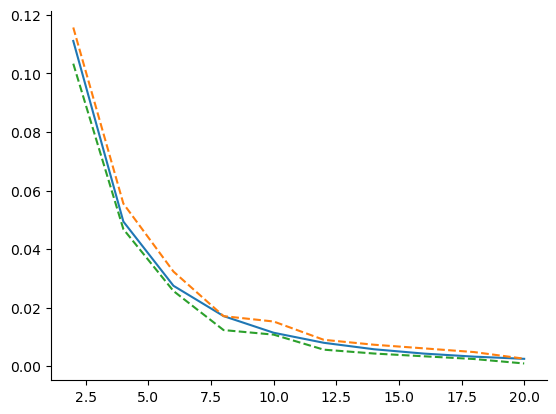

In [5]:
import scipy
ns  = np.arange(2, 22, 2)
pmf_τ0_MC = np.array([np.mean(τ0s==n) for n in ns])
z = scipy.stats.norm.ppf(0.975, loc=0, scale=1)

pmf_τ0_MC_IC_up = pmf_τ0_MC + z / np.sqrt(K) * np.sqrt(pmf_τ0_MC * (1-pmf_τ0_MC))

pmf_τ0_MC_IC_low = pmf_τ0_MC - x / np.sqrt(K) *  np.sqrt(pmf_τ0_MC * (1-pmf_τ0_MC))
pmf_τ0_true = [pmf_ds(p, x, n) for n in ns]
plt.plot(ns, pmf_τ0_true)
plt.plot(ns, pmf_τ0_MC_IC_up, linestyle="dashed")
plt.plot(ns, pmf_τ0_MC_IC_low, linestyle="dashed")
sns.despine()